In [2]:
from google.colab import files

# pick your YOLO weight file
uploaded = files.upload()      # choose best.pt from your computer


Saving best.pt to best.pt


In [3]:
!mkdir -p model
!mv model.pt model/taco_yolov5_best.pt

mv: cannot stat 'model.pt': No such file or directory


In [5]:
# install YOLOv8 / ultralytics package
!pip install ultralytics


In [6]:
!ls -lh


total 50M
-rw-r--r-- 1 root root  50M Oct  5 07:17 best.pt
drwxr-xr-x 2 root root 4.0K Oct  5 07:18 model
drwxr-xr-x 1 root root 4.0K Oct  2 13:36 sample_data


In [7]:
from ultralytics import YOLO

detector = YOLO("best.pt")      # just point to the file that exists
print(f"Loaded {len(detector.names)} classes.")


Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.
Loaded 60 classes.


In [8]:
import json, os

# 6 coarse categories for your app
APP_CLASSES = ["glass", "paper", "cardboard", "plastic", "metal", "trash"]

# mapping YOLO’s fine-grained TACO names → your 6 categories
FINE_TO_COARSE = {
    # PLASTIC
    "Other plastic bottle":"plastic","Clear plastic bottle":"plastic","Plastic bottle cap":"plastic",
    "Disposable plastic cup":"plastic","Foam cup":"plastic","Other plastic cup":"plastic",
    "Plastic lid":"plastic","Other plastic":"plastic","Plastic film":"plastic","Six pack rings":"plastic",
    "Garbage bag":"plastic","Other plastic wrapper":"plastic","Single-use carrier bag":"plastic",
    "Polypropylene bag":"plastic","Crisp packet":"plastic","Spread tub":"plastic","Tupperware":"plastic",
    "Disposable food container":"plastic","Foam food container":"plastic","Other plastic container":"plastic",
    "Plastic glooves":"plastic","Plastic utensils":"plastic","Plastic straw":"plastic",
    "Squeezable tube":"plastic","Styrofoam piece":"plastic",

    # GLASS
    "Glass bottle":"glass","Broken glass":"glass","Glass cup":"glass","Glass jar":"glass",

    # PAPER & CARDBOARD
    "Toilet tube":"cardboard","Other carton":"cardboard","Egg carton":"cardboard","Drink carton":"cardboard",
    "Corrugated carton":"cardboard","Meal carton":"cardboard","Pizza box":"cardboard",
    "Paper cup":"paper","Magazine paper":"paper","Tissues":"paper","Wrapping paper":"paper",
    "Normal paper":"paper","Paper bag":"paper","Plastified paper bag":"paper","Paper straw":"paper",

    # METAL
    "Aluminium foil":"metal","Aluminium blister pack":"metal","Food Can":"metal","Aerosol":"metal",
    "Drink can":"metal","Metal bottle cap":"metal","Metal lid":"metal","Pop tab":"metal","Scrap metal":"metal",

    # EVERYTHING ELSE → TRASH
    "Battery":"trash","Carded blister pack":"trash","Food waste":"trash","Rope & strings":"trash",
    "Shoe":"trash","Unlabeled litter":"trash","Cigarette":"trash"
}


In [9]:
# YOLO class names
taco_names = [detector.names[i] for i in sorted(detector.names.keys())]

missing = [n for n in taco_names if n not in FINE_TO_COARSE]
extra   = [k for k in FINE_TO_COARSE if k not in taco_names]

print("Missing (will default to trash):", missing)
print("Extra keys (typos?):", extra)


Missing (will default to trash): []
Extra keys (typos?): []


In [10]:
os.makedirs("model", exist_ok=True)

with open("model/fine_to_coarse.json","w",encoding="utf-8") as f:
    json.dump(FINE_TO_COARSE, f, indent=2)

with open("model/app_labels.json","w",encoding="utf-8") as f:
    json.dump(APP_CLASSES, f, indent=2)

print("Saved JSON files in /content/model/")


Saved JSON files in /content/model/


In [11]:
from google.colab import files
files.download("model/fine_to_coarse.json")
files.download("model/app_labels.json")
files.download("best.pt")   # or taco_yolov5_best.pt if you renamed it


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [12]:
from google.colab import files
files.upload()      # choose fine_to_coarse.json
files.upload()      # choose app_labels.json


Saving fine_to_coarse.json to fine_to_coarse.json


Saving app_labels.json to app_labels.json


{'app_labels.json': b'[\n  "glass",\n  "paper",\n  "cardboard",\n  "plastic",\n  "metal",\n  "trash"\n]'}

In [13]:
!ls

app_labels.json  best.pt  fine_to_coarse.json  model  sample_data


In [14]:
from ultralytics import YOLO
import json
from PIL import Image

# 1. Load YOLO model
model = YOLO("best.pt")

# 2. Load the mapping and classes
with open("fine_to_coarse.json") as f:
    FINE_TO_COARSE = json.load(f)

with open("app_labels.json") as f:
    APP_CLASSES = json.load(f)

def map_to_coarse(fine):
    return FINE_TO_COARSE.get(fine, "trash")


In [15]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


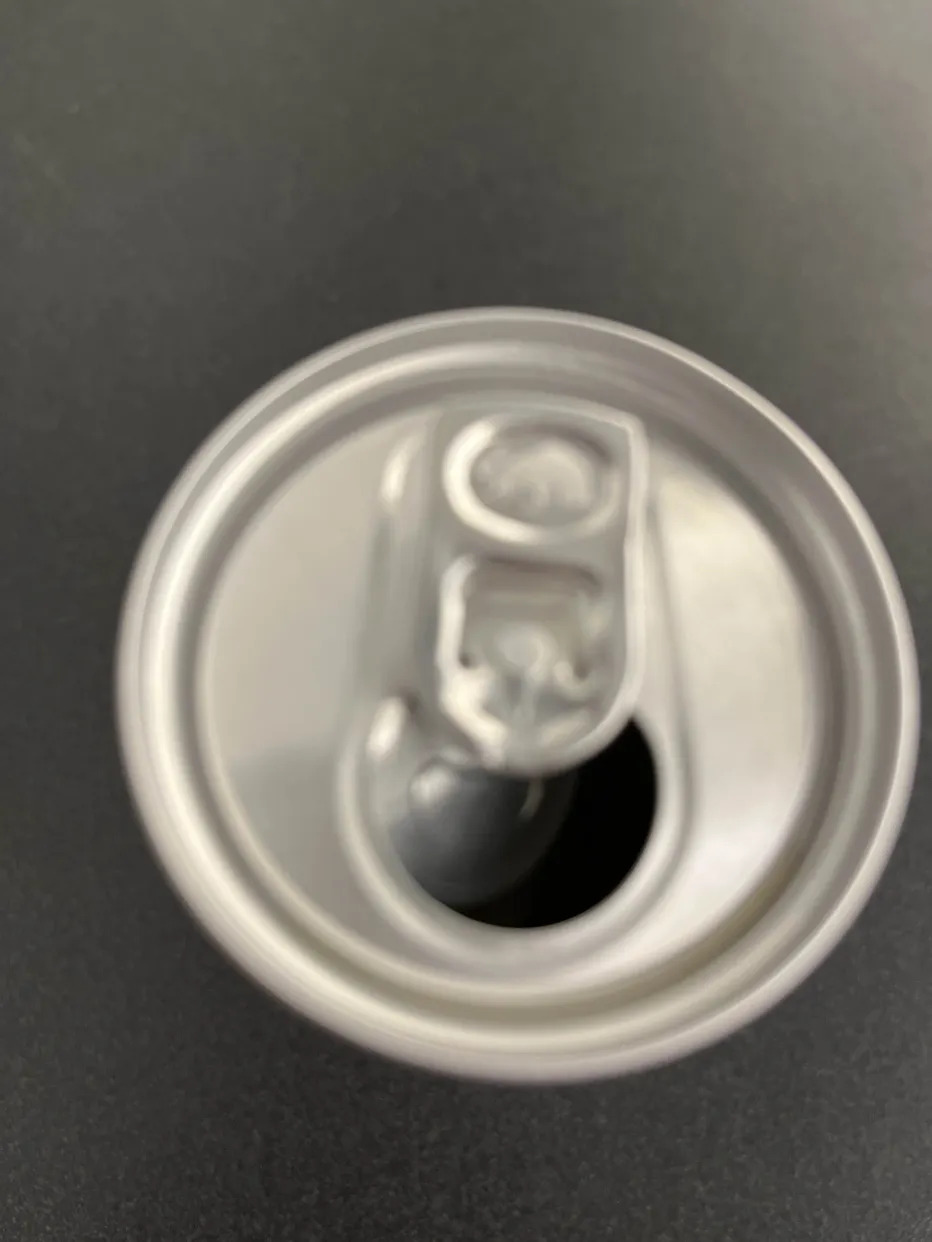

In [16]:
from PIL import Image

img_path = "/content/drive/MyDrive/some_test_photo/image.jpg"
img = Image.open(img_path)
img   # displays in the notebook


In [20]:
from ultralytics import YOLO
model = YOLO("best.pt")

print("task:", getattr(model, "task", None))
print("num classes:", len(model.names))
print("some class names:", list(model.names.values())[:10])


task: detect
num classes: 60
some class names: ['Aluminium foil', 'Battery', 'Aluminium blister pack', 'Carded blister pack', 'Other plastic bottle', 'Clear plastic bottle', 'Glass bottle', 'Plastic bottle cap', 'Metal bottle cap', 'Broken glass']



0: 640x480 (no detections), 995.3ms
Speed: 4.0ms preprocess, 995.3ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 480)


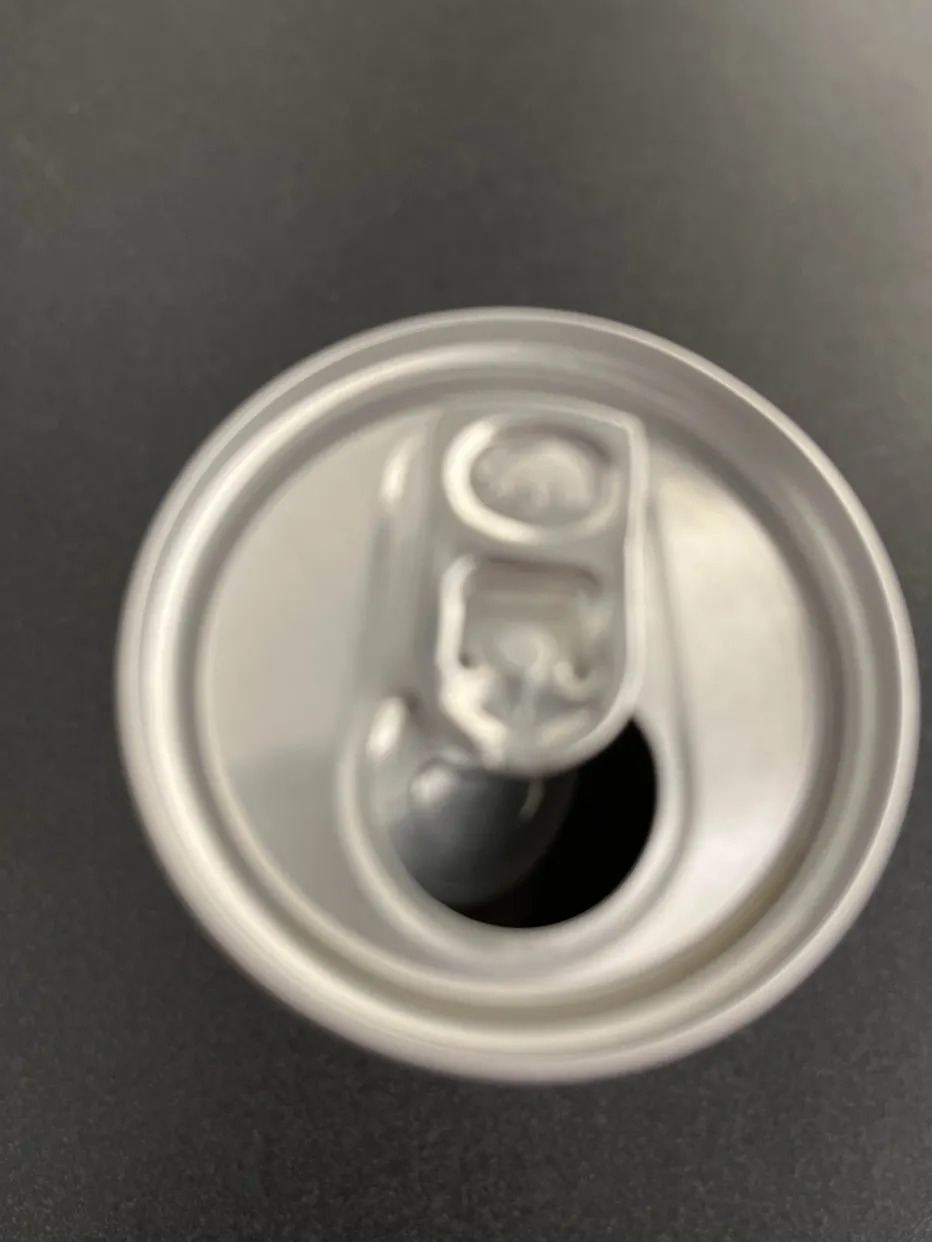

Still no detections.


In [21]:
results = model.predict(source=img, imgsz=640, conf=0.1, verbose=True)
r = results[0]
r.show()
if len(r.boxes):
    for box, cls, conf in zip(r.boxes.xyxy, r.boxes.cls, r.boxes.conf):
        fine = model.names[int(cls)]
        coarse = FINE_TO_COARSE.get(fine, "trash")
        print(f"{fine:30s} → {coarse:10s} conf={conf:.2f}")
else:
    print("Still no detections.")


